# FS20 Fill-Up Question wer/Wahrscheinlichkeitsrechnen (probability calculation)
How to create a spamfilter using bayes' theorem
----


Author: Roman Studer, roman.studer1@students.fhnw.ch

<img src="./data/bayes.jpg"
     alt="A blue neon sign showing the simple statement of Bayes’ theorem at the offices of HP Autonomy"/>
[Image source](https://en.wikipedia.org/wiki/Bayes%27_theorem#/media/File:Bayes'_Theorem_MMB_01.jpg)

----
# Introduction
> In probability theory and statistics, Bayes' theorem (alternatively Bayes' law or Bayes' rule) describes the probability of an event, based on prior knowledge of conditions that might be related to the event. [Wikipedia](https://en.wikipedia.org/wiki/Bayes%27_theorem)

This Notebook is dedicated to the exploration of the Bayes' theorem through the creation of a spam filter. Bayes' theorem has many applications. For example, in statistics, bioinformatics, quality management or the filtering of e-mails. The basic idea of Bayes' theorem is that the probability of the occurrence of an event (under the condition that another event has taken place) can be calculated. The keyword is conditional probability.

In [29]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt    
import itertools
import operator
pd.options.mode.chained_assignment = None

## Bayes' theorem explained
The basic formula: 
$$
P(A \vert B) = \frac{P(B \vert A)P(A)}{P(B)}
$$
- $P(A \vert B)$ is the posterior belief or the probability of getting A given B, a conditional probability
- $P(B \vert A)$ is the likelihood or the probability of getting class B given A
- $P(A)$ and $P(B)$ are prior beliefs. $P(B)$ acts as constant to normalize the result. $P(B)$ (the denominator) is also called evidence.

## Task definition
**Spam detection using a Bayesian filter.**
>Naive Bayes classifiers are a popular statistical technique of e-mail filtering. They typically use bag of words features to identify spam e-mail, an approach commonly used in text classification.
[(taken from wikipedia)](https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering)

The goal is to create a filter that flags spam e-mail in a test set reasonably well. Optimization and decision making isn't the target of this exercise and won't be taken into consideration that much.

## Dataset
Dataset with labeled spam emails as well as harmless emails which allows a train/test split.  
Example: https://archive.ics.uci.edu/ml/datasets/Spambase  

The Dataset has 5728 E-Mails and two columns:
- column 'text', string containing the content of an e-mail
- column 'spam', int (binary) which classifies an e-mail as spam (1) or ham (0)

In [2]:
# read dataset
data = pd.read_csv('data/emails.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [3]:
data.iloc[2][0] # spam e-mail example

'Subject: unbelievable new homes made easy  im wanting to show you this  homeowner  you have been pre - approved for a $ 454 , 169 home loan at a 3 . 72 fixed rate .  this offer is being extended to you unconditionally and your credit is in no way a factor .  to take advantage of this limited time opportunity  all we ask is that you visit our website and complete  the 1 minute post approval form  look foward to hearing from you ,  dorcas pittman'

## Delivery
The following deliverables have been defined and will be included in the submitted work:
- An adaptive spam classifier adapted to the dataset in a Jupyter notebook  
- Including code documentation. 
----

# Definition of a naive bayes classifier 

## Description
The probability that an email is a spam message if a word $w$ occurs is defined by the probability that word $w$ is in a spam message $s$ multiplied by the general probability that the email is a spam message $s$. This gets divided by the probability of that word occurring  in an e-mail (spam and ham combined).

$$
P(s \vert w) = \frac{P(w \vert s)P(s)}{P(w \vert s\cup h)}
$$

To decide if an email is spam, we need to get a single probability $p$ for the whole email and not just for the single words ($p_1$ to $p_n$). Because the spam filter uses a bayesian approach we can achieve this by multiplying the probabilities for every word together and dividing by the combined probability of every word for being in a spam message plus the combined probability of every word for _not_ being in a spam message. The formula to achieve this looks as follows: 

$$
P = \frac{p_1 p_2 ... p_n}{p_1 p_2 ... p_n + (1- p_1)(1-p_2)...(1-p_n)}
$$

Now that we have the probability of an e-mail being spam we need to _decide_ if the e-mail is a spam message or not. This falls into decision theory and is not part of this work. Nevertheless, we want a functional classifier. With the help of a rudimentary parameter search we can define a limit value. If the spamminess of an email is higher than that threshold value, it is classified as spam and gets the value 1 (spam). Below this value it is a harmless e-mail and receives the value 0 (ham).

## Procedure
To create a functioning spam filter we need to do the following steps:
1. Filter filler words and special characters out of e-mail
2. Split data into test and train set
3. Calculate the total probability of an e-mail being spam or ham ($P(s)$ and $P(\lnot s)$)
4. Calculate the conditional probability of a word occurring in a spam ($P(w \vert s)$)
5. Calculate the total probability of $P$ (spamminess) for every email in the train set.
6. Search for best threshold
7. Test on test set
8. Evaluate results

----
# Building a naive bayes spam classifier 
This chapter goes trough the predefined steps to create a spam filter.


## Removal of filler words and special characters
Many words don't carry any meaning for a spam filter. These words are considered as filler words and may be useful if you want to consider the context of an e-mail. But because Bayes' theorem looks at every word independently (_naive_) we can't make any use of context. Filler words/characters are for example pronouns, articles and special characters. We remove those words and characters by filtering them out with the function `rm_filler`.

In [4]:
# filler words, source = https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
en = ['subject:','i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 
      'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 
      'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 
      'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 
      'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 
      'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 
      'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 
      'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 
      'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 
      'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 
      'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", '~', ':', "'", '+', '[', '\\', '@', '^', '{', '%', '(', '-', '"', '*', '|', ',', '&', '<', 
      '`', '}', '.', '_', '=', ']', '!', '>', ';', '?', '#', '$', ')', '/']

In [5]:
def rm_filler(text):
    '''
    Removes (rm) all the filler words of the english language in a str including special characters
    
    :param text: string of words 
    :return text_new: string without filler words
    '''
    if type(text) != str:
        raise TypeError(f"Function only accepts str. {data.type} given")
    
    words = text.lower().split()
    words = [word for word in words if word not in en and len(word) >= 5]
    
    text_new = ' '.join(words)
    
    return text_new

In [6]:
data['text'] = data.text.apply(rm_filler)
data.sample(5)

,text,spam
2778,management vince thanks pedro fernando vince k...,0
4241,kaminski enron molly would invite interview co...,0
512,money 21362 homeowner approved fixed offer ext...,1
5040,organization announcement pleased announce fol...,0
2254,paper request informs meeting antonio regret i...,0


The text in our dataset has now been cleared of filler words and special characters. Additionally we now use only lower case characters (`.lower()`) and got rid of the leading "Subject:" in every email. To simplify the process we only take words with more or equal to 5 letters. This seems to yield better results, which playing around with the notebook has proven.

##  Train/Test split

The dataset contains in total 5728 Emails with the label $0$ for ham or $1$ for spam. Over a quarter of the E-Mails are spam (1368 out of 5728). The next step is to split the dataset into a test and train set. The test set size is set for 0.3 or 30% to have some consistency we set the random_state of the `train_test_split`-function to 42.

In [7]:
print(f'Shape of Dataset: {data.shape}')
print('Number of ham (0) and spam (1) emails:')
data['spam'].value_counts()

Shape of Dataset: (5728, 2)
Number of ham (0) and spam (1) emails:


0    4360
1    1368
Name: spam, dtype: int64

In [8]:
# split data into test and training set
train, test = train_test_split(data, test_size=0.3, random_state=42)
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (4009, 2)
Test shape: (1719, 2)


In [9]:
train = train.reset_index()
print(f'Number of ham (0) and spam (1) emails in train set')
print(train.spam.value_counts())

Number of ham (0) and spam (1) emails in train set
0    3082
1     927
Name: spam, dtype: int64


The dataset is now split into a train (4009 e-mails) and a test set (1719 e-mails).

----
## Probability of an email beeing spam or ham (prior belief)
Now that we have the set split into a train and test set we can calculate the Probability of an E-Mail being spam or ham. This is quite simple. We simply take the number of spam/ham emails $\text{n_spam}$ or $\text{n_ham}$ and divide them by the total number of emails $\text{n_emails}$. Another approach is to use an even probability for spam or ham (0.5) this eliminates the a priori assumption that an e-mail is more likely to be ham. $\text{n_spam}$ is called a _prior belief_.

$$
P(\text{s}) = \frac{\text{n_spam}}{\text{n_emails}} = 0.24
$$

$$
P(\text{h}) = \frac{\text{n_ham}}{\text{n_emails}} = 0.76
$$

In [10]:
p_spam = len(train.loc[train['spam']==1])/len(train) # length of dataset with spam == 1 divided by length of the whole dataset
p_ham = len(train.loc[train['spam']==0])/len(train) # length of dataset with spam == 0 divided by length of the whole dataset
print(f'Probability of an email being spam: {np.round(p_spam, 2)}')
print(f'Probability of an email being ham: {np.round(p_ham, 2)}')

# and to be save, a sanity check: p_spam + p_ham should equal 1
print(f'Combined probability: {p_spam + p_ham}')

Probability of an email being spam: 0.23
Probability of an email being ham: 0.77
Combined probability: 1.0


This of course also gives us the probability of an email _not_ being spam or ham. This is calculated by subtracting the probability from 1, $P(\lnot s) = 1 - P(s)$

----

## Likelihood of a word to be in a spam email or in a ham email (likelihood)
The probability that a word is found in a spam email ($P(w \vert s)$) is defined by the number of occurrences of the word in spam emails divided by the total number of spam emails. The same goes for the probability that a word is in a ham email ($P(w \vert \lnot s)$). This approach does not take into account if a word is in an email multiple times or in what relation the words are to each other. This means that context does not affect anything. Sentences like "FREE! FREE! stuff", which indicate spam, are not interpreted as such but instead get viewed as a unique word count with the words "free" and "stuff". In our case $P(w \vert s)$ is the likelihood of a word appearing in a spam message. 

$$
P(w \vert s) = \frac{\text{number of spam emails containing} \: w}{\text{total number of spam emails}}
$$

$$
P(w \vert \lnot s) = \frac{\text{number of ham emails containing} \: w}{\text{total number of ham emails}}
$$

To do this effectively we can create a dictionary containing all the words (except filler words) of the email in the train set and precalculate the probability of a word being in a spam mail or ham mail.

In [11]:
def p_word(df, mode=0):
    """
    Creates a dictionary for every word in spam/ham emails as a key with the probability of it being in a spam/ham mail as the value.
    :param df: dataframe with two columns: text and label
    :param mode: defines if the return has words in spam or ham mails or both (accepts '0'(ham) and '1'(spam) or '2'(spam and ham))
    :return dictionary with key='word' and value='probability'
    """
    if mode == 0 or mode == 1:
        df = df[df['spam'] == mode] # get spam or ham emails
    
    
    # get list of unique words
    unique = list(df['text'].str.split(' ', expand=True).stack().unique())
        
    # convert list to dict with initial value
    dict_unique = {i : 0 for i in unique}
    
    t_mail = len(df)
    
    for row in df.iterrows():
        text = row[1][1]
        # get list of words 
        words = list(set(text.split())) # convert list to set to get unique values
        # increment value in dict by one for word in words
        for word in words:
            dict_unique[word] += 1
            
    # calculate probability of email being spam given a word:
    t_mail = len(df) # number of emails in df
    dict_prob = {k: (v / t_mail) for k, v in dict_unique.items()}

    return dict_prob

spam = p_word(train, mode=1)
ham = p_word(train, mode=0)
spam_ham = p_word(train, mode=2)

In [12]:
dict(itertools.islice(spam.items(), 5))

{'locations': 0.006472491909385114,
 'orlando': 0.002157497303128371,
 'vegas': 0.005393743257820928,
 'congratulations': 0.014023732470334413,
 'receiving': 0.0744336569579288}

## Calculate the "spam" probability for every e-mail (posterior)
For a better explanation of what is going on in `prob()` we need to see our equations again:
$$
P(s \vert w) = \frac{P(w \vert s)P(s)}{P(w \vert s\cup h)}
$$

$$
P = \frac{p_1 p_2 ... p_n}{p_1 p_2 ... p_n + (1- p_1)(1-p_2)...(1-p_n)}
$$

For an efficient calculation we can merge this two equations into one:
$$
P = \frac{P(s) \prod_{i=1}^n P(w_i \vert s)}{\prod_{i=1}^n P(w_i \vert s \cup h)}
$$
The probability that a word is found in a spam email ($P(w \vert s)$) is defined by the number of occurrences of the word in spam emails divided by the total number of spam emails. The same goes for the probability that a word is in a ham email ($P(w \vert \lnot s)$). This approach does not take into account if a word is in an email multiple times or in what relation the words are to each other. This means that context does not affect anything. Sentences like "FREE! FREE! stuff", which indicate spam, are not interpreted as such but instead get viewed as a unique word count with the words "free" and "stuff". In our case $P(w \vert s)$ is the likelihood of a word appearing in a spam message. 

In [13]:
def prob(text):
    """
    Calculate the total probability of an incomming e-mail being spam
    """
    words = list(set(text.split()))
    
    numerator = 1
    denominator2 = 1
    for word in words:
        if word in spam.keys():
            numerator *= spam[word]
            denominator2 *= spam_ham[word]
                
    numerator *= p_spam
    denominator2 *= p_ham
    if numerator == 0:
        return 0
    else:
        return numerator/(numerator+denominator2)

train['prob'] = train['text'].apply(prob)
test['prob'] = test['text'].apply(prob)

train.sample(5)

,index,text,spam,prob
3027,2645,spread options short follow options attached c...,0,2.243515e-08
1636,2260,departure grant masson research group sense re...,0,1.145448e-10
85,2954,storage meeting believe might additions group ...,0,1.027883e-24
2706,545,offrr liberalize northward dlcatlons centr com...,1,1.000000e+00
1744,3830,exotica advice sharad process finding differen...,0,4.409711e-11


We can visualize our result in the `prob` column by plotting a histogram. It seems that the Bayesian approach tends to push values to the extremes of $0$ and $1$. This makes sense, because our model knows all words of the training data. 

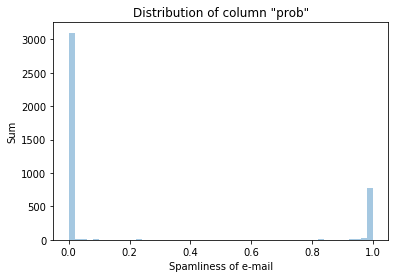

In [28]:
fig = sns.distplot(train.prob, kde=False)
fig.set(title= 'Distribution of column "prob"', xlabel='Spamliness of e-mail', ylabel='Sum')
plt.show()

## Classification with threshold and parameter search
Now that we have our function that calculates the probabilities for our e-mails we could run this on our test set and call it a day. But that is not the case. We need to decide at what point we flag an e-mail as spam. We are going to test a few different thresholds in our `classification`-function. I set our target to minimize the false positives. We do not want that legitimate e-mails land in the junk drawer. 

In [15]:
def classification(val, threshold):
    """
    Classifies data into binary value, 0 for ham and 1 for spam
    :param val: Value which should be classified
    :param theshold: Threshold for binary classification
    :return val: binary value
    """
    if val >= threshold:
        val = 1 
    else:
        val = 0
    return val

In [47]:
# apply classification on dataset
param = {}
spam = sum(train.loc[train['spam']==1, 'spam'])
best_fp, best_acc, best_fn_param, best_acc_param = None, 0, 0.01, 0.01

for i in np.arange(0.01,1,0.01):
    train.loc[:,'class'] = train.prob.apply(classification, threshold = i)
    tp = sum(train.loc[train['spam']==1,'class']==1)     # true positive
    tn = sum(train.loc[train['spam']==0,'class']==0)     # true negative
    fp = sum(train.loc[train['spam']==0,'class']==1)     # false positive
    fn = sum(train.loc[train['spam']==1,'class']==0)     # false negative
    p = len(train.loc[train['spam']==1,'spam'])          # actual postive
    n = len(train.loc[train['spam']==0,'spam'])          # actual negative
   
    # sensitivity (true positive / real positive)
    sensitivity = tp/(tp+fn) # true positive rate
    
    # specificity (true negative / real negative)
    specificity = tn/(tn+fn) # true negative rate 
    
    # accuracy ((true positive + true negative)/(real positive + real negative))
    accuracy = (tp+tn)/(p+n)    
    
    param[i] = (sensitivity,specificity,accuracy)
    
    if best_fp is None:
        best_fp = fp
    elif best_fp > fp:
        best_fp = fp
        best_fn_param = i
    if best_acc < accuracy:
        best_acc = accuracy
        best_acc_param = i
    
print(f'Parameter with least false positives: {best_param}')
print(f'Parameter with best accuracy: {best_acc_param}')

Parameter with least false positives: 0.88
Parameter with best accuracy: 0.39


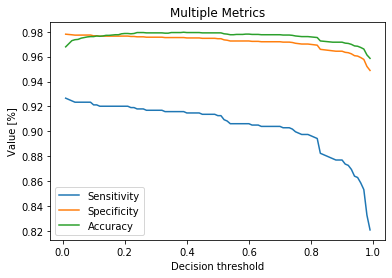

In [33]:
for i in range(3):
    plt
    fig = sns.lineplot(list(param.keys()),[a_tuple[i] for a_tuple in list(param.values())])

# add legend to plot
labels = ['Sensitivity', 'Specificity', 'Accuracy']
fig.legend(labels)


# add descriptions to plot
fig.set(title= 'Multiple Metrics', xlabel='Decision threshold', ylabel='Value [%]')

plt.show()

The plot above visualizes a few measurements like accuracy, specificity and sensitivity on our trainset. But these aren't the parameters I'm interested in. What a spam filter should not do is flag harmless e-mails or in other words should have a very low number of false positives.

----
# Results

Now that we have found a parameter that fits our needs, we can test our classifier on the test set. Below we apply our best threshold that we got to the train and the test set and plot a corresponding confusion matrix.

In [44]:
train['class'] = train.prob.apply(classification, threshold = best_fn_param)
test['class'] = test.prob.apply(classification, threshold = best_fn_param)

In [42]:
def plot_confusion_matrix(data,name_dataset):
    """
    Plots a confustion matrix using scipys confusion_matrix function
    :param data: datset wich needs columns 'spam' and 'class' with numeric values
    :param name_dataset: name of the dataset to set a title
    """
    cm = confusion_matrix(data['spam'], data['class'])

    ax= plt.subplot()
    sns.heatmap(cm, annot = True, fmt='g')

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix, {name_dataset}') 
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    plt.show()

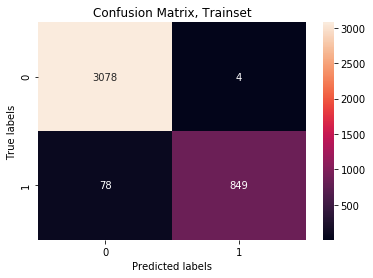

In [45]:
plot_confusion_matrix(train, 'Trainset')

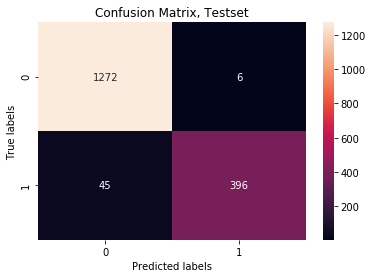

In [46]:
plot_confusion_matrix(test, 'Testset')

As we can see in the confusion matrix above we get some good results. Only two e-mails in our test set have been falsely flagged as spam (false positive). A bit of an inconvenience are the 90 spam e-mails that haven't been flagged as spam and were classified as harmless e-mails (false negative). Sorry that you had so see emails about unwanted viagra offers or free money a Nigerian prince wants to send you for a small fee. 

The accuracy of this classifier is over 94% on the test set. 

----
# Discussion
What are the consequences of deciding to treat a new observation as class 1 vs. 0? If we falsely classify a legitimate e-mail as spam the customer could lose trust in the spam filter or miss crucial information that has been sent to him. The false-positive number should be as low as possible to prohibit that. A high accuracy also ensures that most emails get classified correctly which means that false negatives fall as well. The above-created spam classifier achieves this reasonably well for a prototype. There is still much room for improvement. The false negatives are numerous which stick out like a sore thumb. A way to tune that would be to focus on words that appear regularly because they are a better indicator than words that appear only a few times, which carry less meaning. 

All in all the classifier is a success for a simple exercise. We achieved an accuracy of over 94%.

----
# Sources
- „Naive Bayes Spam Filtering“. 2020. Wikipedia. https://en.wikipedia.org/w/index.php?title=Naive_Bayes_spam_filtering&oldid=948460671 (April 18, 2020).
- „Bayes’ Theorem“. 2020. Wikipedia. https://en.wikipedia.org/w/index.php?title=Bayes%27_theorem&oldid=951581312 (April 18, 2020).
- Bayes Theorem. https://www.youtube.com/watch?v=HZGCoVF3YvM (April 18, 2020).
- “Removing Stop Words with NLTK in Python.” 2017. GeeksforGeeks. https://www.geeksforgeeks.org/removing-stop-words-nltk-python/ (April 18, 2020).




----
# Glossary
**Accuracy** true positive + true negative divided by number of events, a ratio of correct classifications

**A priori** presupposed by experience

**Ham** the opposite of spam, an e-mail that the recipient wants to receive

**Likelihood** probability of getting B if given A

**Prior belief** expresses belief before taking evidenve into account

**Sensitivity** measures the proportion of actual postitives that are correctly identified as such

**Spam** an unsolicited or fraudulent e-mail

**Specificity** measures the proportion of actual negatives that are correctly identified as such
